In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

import pppc
from pppc.configs import InferenceConfigDict
from pppc.ptychonn.model import PtychoNNModel, PtychoNNTransposedConvModel
from pppc.reconstructor import DatasetInferencer, TileStitcher
from pppc.position_list import ProbePositionList
from pppc.io import NPZFileHandle

os.chdir('/data/programs/probe_position_correction_w_ptychonn/workspace/large')

[2024-02-08 18:13:28,028] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-02-08 18:13:28,032] NumExpr defaulting to 8 threads.


In [3]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [4]:
def clean_data(arr):
    mask = arr < 0
    vals = arr[mask]
    vals = 32768 + (vals - -32768)
    arr[mask] = vals
    return arr

def plot_distribution(x):
    x = x.reshape(-1)
    #x = x[x > 0]
    plt.hist(x, bins=32)
    plt.semilogy()
    plt.show()

In [5]:
scan_idx = 221
save_figs = True

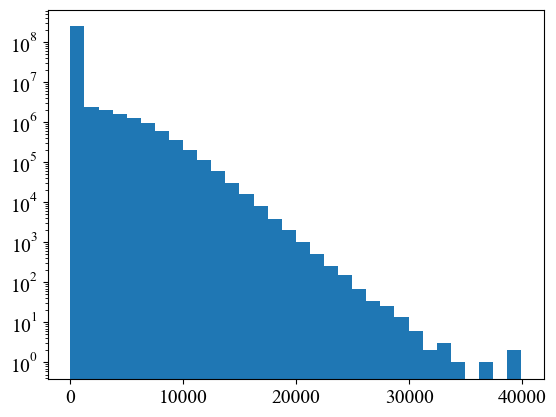

(961, 512, 512) int32


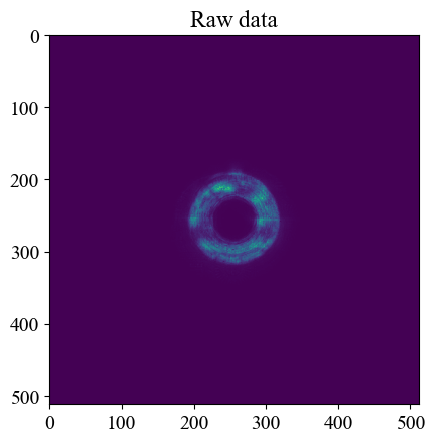

In [11]:
#psize_nm = np.load('data/scan221_raw.npz')['pixelsize'] * 1e9
psize_nm = 8
config_dict = InferenceConfigDict()
config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_cleaned_valRatio_10/best_model.pth'
#config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_compWithTransConv_model_PtychoNNModel_nLevels_4_lossFunction_MSELoss_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth'
#config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_TransConv/best_model.pth'
config_dict['model'] = (PtychoNNModel, {'n_levels': 4})
config_dict['batch_size'] = 32
try:
    config_dict['dp_data_file_handle'] = NPZFileHandle('data/test{}.npz'.format(scan_idx))
except:
    config_dict['dp_data_file_handle'] = NPZFileHandle('data/scan{}.npz'.format(scan_idx))
# Correct int16 overflow values
config_dict['dp_data_file_handle'].array = clean_data(config_dict['dp_data_file_handle'].array)
plot_distribution(config_dict['dp_data_file_handle'].array)
print(config_dict['dp_data_file_handle'].array.shape, config_dict['dp_data_file_handle'].array.dtype)
plt.figure()
plt.imshow(config_dict['dp_data_file_handle'].array[0, :, :])
plt.title('Raw data')
plt.show()
# if 244 <= scan_idx <= 246: 
#     config_dict['dp_data_file_handle'].array = config_dict['dp_data_file_handle'].array.astype(float)
#     config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(-64, -64))
# else:
config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(64, 64))
config_dict['cpu_only'] = True
config_dict['prediction_output_path'] = 'outputs/pred_{}_{}'.format(
    os.path.splitext(os.path.basename(config_dict['dp_data_file_handle'].f.fid.name))[0],
    os.path.basename(os.path.dirname(config_dict['model_path'])))

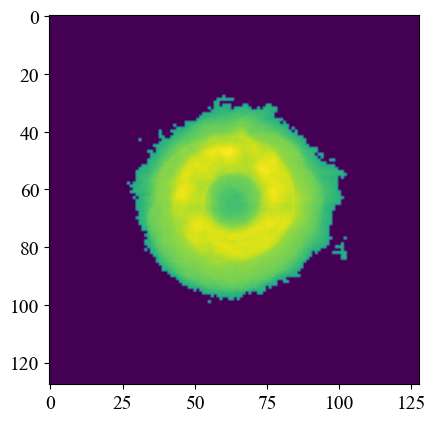

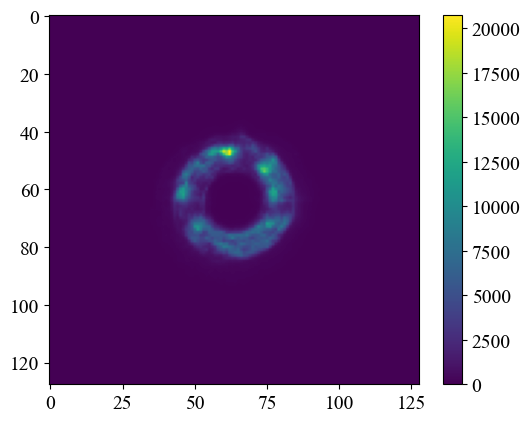

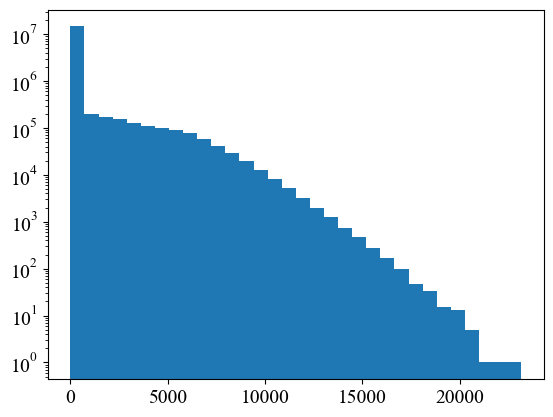

In [46]:
plt.figure()
plt.imshow(np.log10(config_dict['dp_data_file_handle'].array[0, :, :] + 1e-6))
plt.figure()
plt.imshow(config_dict['dp_data_file_handle'].array[0, :, :])
plt.colorbar()
plt.show()
plot_distribution(config_dict['dp_data_file_handle'].array[:, :, :])

In [12]:
inferencer = DatasetInferencer(config_dict)
inferencer.build()
inferencer.run()
inferencer.convert_output_files_into_single_tiff('pred_phase')
inferencer.convert_output_files_into_single_tiff('pred_amp')

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 929/961 [00:26<00:00, 34.97it/s]


## Stitching

In [13]:
config_dict['probe_position_list'] = ProbePositionList(file_path='data/pos221.csv', unit='m', psize_nm=8, convert_to_pixel=False, first_is_x=False)
#config_dict['probe_position_list'] = ProbePositionList(file_path='outputs/test{}/calc_pos_{}_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv'.format(scan_idx, scan_idx), unit='m', psize_nm=8, convert_to_pixel=False, first_is_x=False)
#config_dict['probe_position_list'].array += 50 * 8e-9
config_dict['central_crop'] = (108, 108)

In [14]:
stitcher = TileStitcher(config_dict)
stitcher.build()
stitcher.run()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [00:24<00:00, 39.41it/s]


 13%|██████████████████▍                                                                                                                       | 128/961 [04:13<27:31,  1.98s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/test221/stitched_niters_2_nn_12_sw_1e-2_1e-3.pdf'

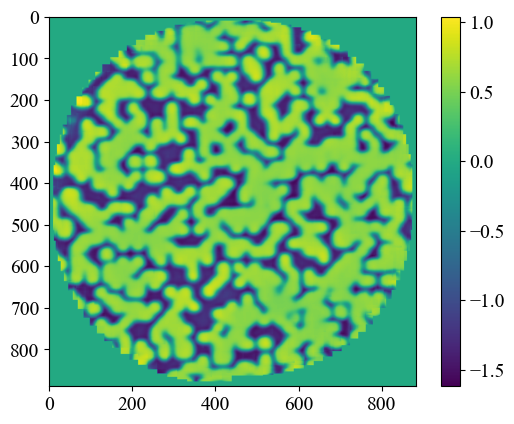

In [15]:
image_stitched_ptychonn = stitcher.image_stitched
fig, ax = plt.subplots(1, 1)
im = ax.imshow(image_stitched_ptychonn)
plt.colorbar(im)
if save_figs:
    plt.savefig('outputs/test{}/stitched_niters_2_nn_12_sw_1e-2_1e-3.pdf'.format(scan_idx))
else:
    plt.show()

In [17]:
import tifffile
tifffile.imwrite('../stitched_ptychonn_preds/s26/stitched_pred.tiff', image_stitched_ptychonn)
import pandas as pd
pd.DataFrame(config_dict['probe_position_list'].array * psize_nm * 1e-9).to_csv('../stitched_ptychonn_preds/s26/pos_m.csv', index=False, header=False)